In [1]:
import model_preprocessing
import model_utils
import scanpy as sc
from sklearn import svm
from sklearn import model_selection

In [2]:
# Read loom matrices that have a 'cellType' obs metadata vector

annData_hca = sc.read_loom("/Users/pgarcia-nietochanzuckerberg.com/projects/cell_type_transfer/pancreas/data/hca_cellTypes.loom")
annData_paper = sc.read_loom("/Users/pgarcia-nietochanzuckerberg.com/projects/cell_type_transfer/pancreas/data/paper_alternative.loom")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# Do some very basic pre-processing: 
# For train set (paper): log1p, filter out genes expressed in <5% cells, and select top 2000 variable genes
# For test set (hca): log1p

annData_paper = model_preprocessing.preprocessing(annData_paper, do_log1p = True, do_min_cells_filter = True, do_select_variable_genes = True)
annData_hca = model_preprocessing.preprocessing(annData_hca, do_log1p = True, do_min_cells_filter = False, do_select_variable_genes = False)

Applying log1p transformation
Applying min cells filter: only keep genes if expressed in at least 5.0 % cells
Selecting 2000.0 variable genes
Applying log1p transformation


In [4]:
# Wrangle data to have objects with the same genes and 
# then extract matrices and label vectors.
# Matrices' rows will be matching (i.e. correspoding genes)

# Select shared genes
annData_hca, annData_paper = model_utils.subset_annData(annData_hca, annData_paper)

# Get matrices and labels
x_hca, cellTypes_hca, x_paper, cellTypes_paper = model_utils.get_mat_and_lab(annData_hca, "cellType", 
                                                                             annData_paper, "cellType")

In [5]:
# Making a model based on the paper data using support vector machine model
# Default hyper parameters -- see below for hyper-parameter optimization

svc = svm.SVC(gamma = "auto")
svc.fit(x_paper, cellTypes_paper)

# Get accuracy of predictor

print ("Model accuracy in traning data (paper): ", str(svc.score(x_paper, cellTypes_paper)))
print ("Model accuracy in test data (HCA): ", str(svc.score(x_hca, cellTypes_hca)))

Model accuracy in traning data (paper):  0.9601593625498008
Model accuracy in test data (HCA):  0.7547169811320755


In [6]:
# Now doing a exhausitive hyper-paramater search based a 5-fold cross-validation strategy

# Recommended gama factor 1/(number of genes * variance of matrix)
gamma_factor = 1 / (x_paper.shape[1] * x_paper.var())
svm_par_grid = model_utils.grid_dict_svm_SVC(gamma_factor)

# Do grid search in hyper par space using cross-validation
svc_grid = model_selection.GridSearchCV(svm.SVC(), svm_par_grid, cv=5, scoring="accuracy", n_jobs=-1)
svc_grid.fit(x_paper, cellTypes_paper)

print("Best parameters")
for key in svc_grid.best_params_:
    print("\t", key, ":", svc_grid.best_params_[key], sep ="")


Best parameters
	C:10
	gamma:4.278499493018364e-05
	kernel:rbf


In [7]:
# Predict using best paramaters found
print ("Model accuracy in traning data (paper): ", str(svc_grid.score(x_paper, cellTypes_paper)))
print ("Model accuracy in test data (HCA): ", str(svc_grid.score(x_hca, cellTypes_hca)))


Model accuracy in traning data (paper):  0.9704040978941377
Model accuracy in test data (HCA):  0.6647012578616353


In [8]:
# Add predictions to orignal hca matrix object
annData_hca.obs["cellTypePredicted"] = svc_grid.predict(x_hca).tolist()
annData_hca.obs["cellTypePredicted_missed"] = annData_hca.obs["cellType"] != annData_hca.obs["cellTypePredicted"] 

Trying to set attribute `.obs` of view, making a copy.


In [9]:
# Do clustering and umaps for plotting

sc.pp.pca(annData_paper)
sc.pp.neighbors(annData_paper)
sc.tl.umap(annData_paper)

sc.pp.pca(annData_hca)
sc.pp.neighbors(annData_hca)
sc.tl.umap(annData_hca)

/miniconda3/envs/test/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../miniconda3/envs/test/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/miniconda3/envs/test/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../miniconda3/envs/test/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/miniconda3/envs/test/lib/python3.7/site-packages/numba/compiler.py:751: Numba

... storing 'analysis_protocol.protocol_core.protocol_id' as categorical
... storing 'analysis_working_group_approval_status' as categorical
... storing 'cellType' as categorical
... storing 'derived_organ_label' as categorical
... storing 'derived_organ_ontology' as categorical
... storing 'derived_organ_part_label' as categorical
... storing 'derived_organ_part_ontology' as categorical
... storing 'donor_organism.development_stage.ontology' as categorical
... storing 'donor_organism.development_stage.ontology_label' as categorical
... storing 'donor_organism.diseases.ontology' as categorical
... storing 'donor_organism.diseases.ontology_label' as categorical
... storing 'donor_organism.human_specific.ethnicity.ontology' as categorical
... storing 'donor_organism.human_specific.ethnicity.ontology_label' as categorical
... storing 'library_preparation_protocol.end_bias' as categorical
... storing 'library_preparation_protocol.input_nucleic_acid_molecule.ontology' as categorical
... sto

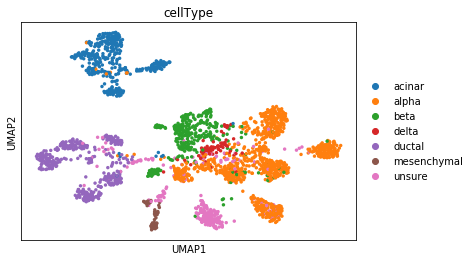

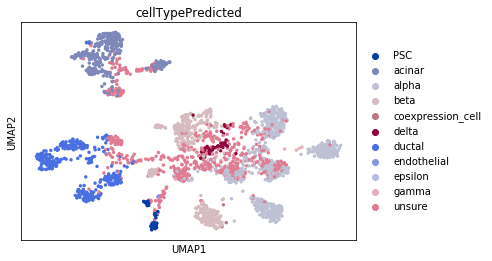

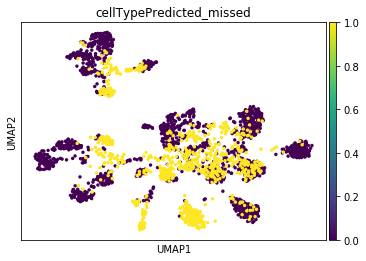

... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment.LIBRARY_SOURCE.' as categorical
... storing 'Comment.LIBRARY_STRAND.' as categorical
... storing 'Comment.LIBRARY_STRATEGY.' as categorical
... storing 'Derived.Array.Data.File' as categorical
... storing 'Factor.Value.cell.type.' as categorical
... storing 'Factor.Value.disease.' as c

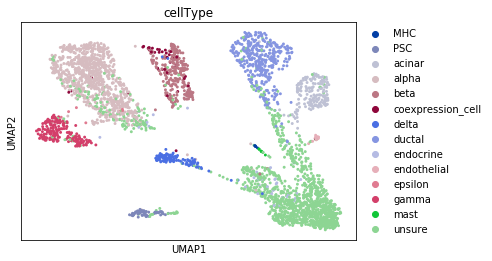

In [10]:
# Plot the results

sc.pl.umap(annData_hca, color="cellType")
sc.pl.umap(annData_hca, color="cellTypePredicted")
sc.pl.umap(annData_hca, color="cellTypePredicted_missed")
sc.pl.umap(annData_paper, color="cellType")